In [1]:
import os
import numpy as np
import pickle
from matplotlib import pyplot as plt

from img_helper import reduce_to_1, reduce_to_V, update_V, hsv2rgb_set, create_plot

from tensorflow.keras.models import load_model

# Fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [2]:
dataset_npy_path="Dataset npys/"
saved_figs_path = "Results/"
trained_models_path = "trained models/"

In [6]:
# load models

stack_encoder = load_model(os.path.join(trained_models_path,'stack_encoder.h5'))

conv_encoder = load_model(os.path.join(trained_models_path,'conv_encoder.h5'))

# summarize model.

stack_encoder.summary()

conv_encoder.summary()

#load training history

with open('trainHistoryDict_stack.pkl',"rb") as f:
    history_stack = pickle.load(f)

with open('trainHistoryDict_conv.pkl',"rb") as f:
    history_conv = pickle.load(f)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100)          0         
_________________________________________________________________
dense (Dense)                (None, 100, 100)          10100     
Total params: 10,100
Trainable params: 10,100
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d

In [7]:
#load data

train_RGB_X = np.load(os.path.join(dataset_npy_path,"train_RGB_X.npy"))
test_RGB_X = np.load(os.path.join(dataset_npy_path,"test_RGB_X.npy"))
train_HSV_X = np.load(os.path.join(dataset_npy_path,"train_HSV_X.npy"))
train_HSV_Y = np.load(os.path.join(dataset_npy_path,"train_HSV_Y.npy"))
train_noisy_HSV_Y = np.load(os.path.join(dataset_npy_path,"train_noisy_HSV_Y.npy"))
test_HSV_X = np.load(os.path.join(dataset_npy_path,"test_HSV_X.npy"))
print("data loaded")

data loaded


In [8]:
# Test dual encoder network
stack_test_V_Y = stack_encoder.predict(test_HSV_X[:,:,:,2])
conv_test_HSV_X = update_V(test_HSV_X, stack_test_V_Y)
conv_test_V_Y = conv_encoder.predict(reduce_to_1(conv_test_HSV_X, 2))
conv_test_HSV_Y = update_V(conv_test_HSV_X, conv_test_V_Y[:,:,:,0])

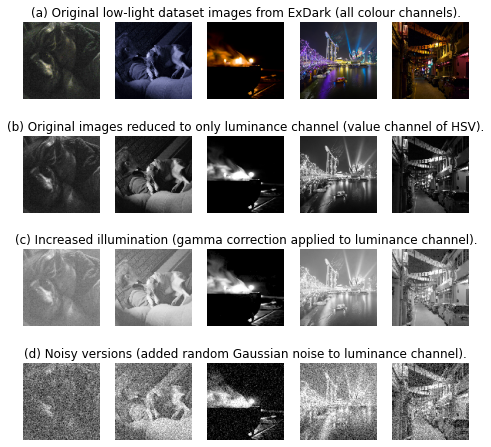

In [9]:
# Modify training images for channel visualization
train_V_X = reduce_to_V(train_HSV_X)
train_V_Y = reduce_to_V(train_HSV_Y)
train_noisy_V_Y = reduce_to_V(train_noisy_HSV_Y)
train_rgbV_X = hsv2rgb_set(train_V_X)
train_rgbV_Y = hsv2rgb_set(train_V_Y)
train_noisy_rgbV_Y = hsv2rgb_set(train_noisy_V_Y)

# Create a figure of sample training images 
plot_data = [train_RGB_X, train_rgbV_X, train_rgbV_Y, train_noisy_rgbV_Y]
plot_titles = ["(a) Original low-light dataset images from ExDark (all colour channels).",
		"(b) Original images reduced to only luminance channel (value channel of HSV).",
		"(c) Increased illumination (gamma correction applied to luminance channel).",
		"(d) Noisy versions (added random Gaussian noise to luminance channel)."]
fig = create_plot(4, 5, plot_data, plot_titles, 10)
fig.set_size_inches(8, 8)
fig.savefig(os.path.join(saved_figs_path,'training_image_samples.jpg'), dpi=2000)
plt.show()

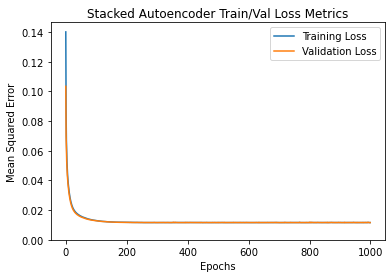

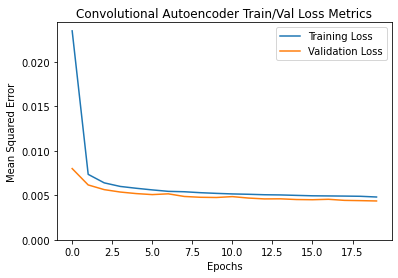

In [14]:
# Plot stacked encoder metrics
stack_fig = plt.figure()
plt.plot(history_stack['loss'], label='Training Loss')
plt.plot(history_stack['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.ylim([0,max(plt.ylim())])
plt.title('Stacked Autoencoder Train/Val Loss Metrics')
plt.show()
stack_fig.savefig(os.path.join(saved_figs_path,'stack_training_metrics.jpg'), dpi=2000)

# Plot convolutional encoder metrics
conv_fig = plt.figure()
plt.plot(history_conv['loss'], label='Training Loss')
plt.plot(history_conv['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.ylim([0,max(plt.ylim())])
plt.title('Convolutional Autoencoder Train/Val Loss Metrics')
plt.show()
conv_fig.savefig(os.path.join(saved_figs_path,'conv_training_metrics.jpg'), dpi=2000)

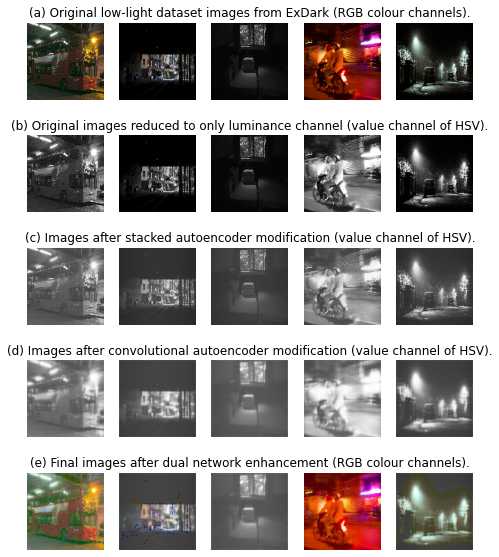

In [15]:
# Modify test images for channel visualization
test_V_X = reduce_to_V(test_HSV_X)
test_rgbV_X = hsv2rgb_set(test_V_X)
conv_test_V_X = reduce_to_V(conv_test_HSV_X)
conv_test_rgbV_X = hsv2rgb_set(conv_test_V_X)
conv_test_V_Y = reduce_to_V(conv_test_HSV_Y)
conv_test_rgbV_Y = hsv2rgb_set(conv_test_V_Y)
conv_test_RGB_Y = hsv2rgb_set(conv_test_HSV_Y)

# Create a figure of sample test images
plot_data = [test_RGB_X, test_rgbV_X, conv_test_rgbV_X, conv_test_rgbV_Y, conv_test_RGB_Y]
plot_titles = ["(a) Original low-light dataset images from ExDark (RGB colour channels).",
        "(b) Original images reduced to only luminance channel (value channel of HSV).",
        "(c) Images after stacked autoencoder modification (value channel of HSV).",
        "(d) Images after convolutional autoencoder modification (value channel of HSV).",
        "(e) Final images after dual network enhancement (RGB colour channels)."]
fig = create_plot(5, 5, plot_data, plot_titles, 5)
fig.set_size_inches(8, 10)
fig.savefig(os.path.join(saved_figs_path,'test_image_samples.jpg'), dpi=2000)
plt.show()